# Creating a point source mask

## Background knowledge

Given some data $\vec{d}$ and some signal of interest, present in the data, $\vec{s}$, we want to apply a linear operation $T$ on the data to have an estimate of the signal:

$\hat{\vec{s}}=T\vec{d},$

in a way such that it can also give some minimum variance estimate.

For some model, we have

$\hat{\vec{s}}=\frac{\vec{s}^TC^{-1}\vec{d}}{\vec{s}^TC^{-1}\vec{s}}$

The standard deviation for the estimated map is

$[\vec{s}^TC^{-1}\vec{s}]^{-1/2}$

The signal-to-noise ratio (SNR) of the detection can be defined as


$\mathrm{SNR}=\frac{\vec{s}^TC^{-1}\vec{d}}{[\vec{s}^TC^{-1}\vec{s}]^{1/2}}$



For a single frequency matched filter we have $T = \frac{B_lS_l}{B_l^2N_{\mathrm{ap},l}+N_{\mathrm{ins},l}}$

$N_{\mathrm{ap},l}$ is the power spectrum (e.g., absolute value squared of the 2d FFT) of the astrophysical noise from sources other than what is desired to be found

$N_{\mathrm{ins},l}$ is the power spectrum of the instrumental response.




## References

Using the kinematic Sunyaev-Zeldovich effect to determine the peculiar
velocities of clusters of galaxies, Martin G. Haehnele and Max Tegmark [1]

Understanding matched filters for precision cosmology, Inigo Zubeldia, Aditya Rotti, Jens Chluba and Richard Battye [2]

https://github.com/Saladino93/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_05.ipynb [3]


Catalog Extraction in SZ Cluster Surveys: a matched filter approach, Jean–Baptiste Melin, James G. Bartlett, and Jacques Delabrouille [4]

## Codes

https://github.com/ACTCollaboration/dr6_lensing_fgs/blob/86515bba70400c4f4edffd327826a26e08d92abd/websky_tests/match_filter.py

https://github.com/EmmanuelSchaan/LensQuEst/blob/master/flat_map.py#L842

https://github.com/Saladino93/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_05.ipynb

https://github.com/ACTCollaboration/dr6_lensing_fgs/blob/5eef0376462e0b338410b17f452fd33595040730/websky_tests/prepare_psmask.py







In [1]:
import pathlib

import healpy as hp

from pixell import curvedsky as cs

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline



## Define some utility functions, a bit copied from falafel

In [2]:

def get_mlmax(alms):
    if alms.ndim==2:
        asize = alms[0].size
    elif alms.ndim==1:
        asize = alms.size
    else:
        print(alms.shape)
        raise ValueError
    return hp.Alm.getlmax(asize)

def filter_alms(alms, filt, lmin = None, lmax = None):
    """
    Filter the alms with transfer function specified
    by filt (indexed starting at ell=0).
    """
    mlmax = get_mlmax(alms)
    ls = np.arange(filt.size)
    if lmax is not None:
        assert lmax<=ls.max()
        assert lmax<=mlmax
    if lmin is not None: filt[ls<lmin] = 0
    if lmax is not None: filt[ls>lmax] = 0
    return cs.almxfl(alms.copy(), filt)

def gauss_beam(ell: np.ndarray, fwhm: float):
    '''
    Parameters
    ----------
    ell: np.ndarray
    fwhm: float, in arcmin

    Returns
    -------
    gauss_beam: np.ndarray
    '''
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))



## Read foreground maps

In [3]:
import constants as const

import foregrounds_utils as fgsu


In [4]:
nside = 4096
mlmax = 6000

source_dir = pathlib.Path('/global/cscratch1/sd/omard/scatteringtfms/sims/')

In [5]:
cmboutname = 'cmb'
kappaoutname = 'kappa'
kszoutname = 'ksz'
tszoutname = 'tsz'
radiooutname = 'radio'
ciboutname = 'cib'


In [6]:
freq = 145

nomifgs = [kszoutname, tszoutname, radiooutname, ciboutname]
totalfgs = np.sum([hp.read_alm(source_dir/f'{nome}_alm.fits')*(fgsu.tsz_factor_for_ymap(freq) if nome == tszoutname else 1) for nome in nomifgs], axis = 0)

#### This is the input cmb sky spectra for one fixed frequency

In [8]:
cmb_power = 'CMB_PS_healpix_Nside4096_DeltaT_uK_SimLensCMB.txt'
ell, clcmb = np.loadtxt(source_dir/cmb_power, unpack = True)

allelementstosave = np.load('input_cmb_145.npy')
ells, lcmb, tsz, ksz, radio, cib, dust, nl145, totalcmb, totalnoisecmb = allelementstosave.T

In [9]:
freq = 145 #GHz

tsz_power = 'Sehgal_sim_tSZPS_unbinned_8192_y_rescale0p75.txt'
ksz_power = 'kSZ_PS_Sehgal_healpix_Nside4096_DeltaT_uK.txt'

ell, cltsz = np.loadtxt(source_dir/tsz_power, unpack = True)
cltsz *= (fgsu.tsz_factor_for_ymap(freq))**2
ell, clksz = np.loadtxt(source_dir/ksz_power, unpack = True)

In [10]:
cltotalfgs = hp.alm2cl(totalfgs)

### Checking some foregrounds spectra

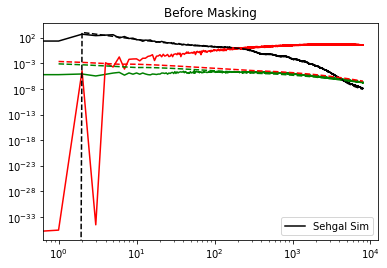

In [11]:
get_factor = lambda l: l*(l+1)/(2*np.pi)

factor = get_factor(ell)
factors = get_factor(ells)

plt.title('Before Masking')
plt.loglog(ell, clcmb, label = 'Sehgal Sim', color = 'black')
plt.loglog(ell, clksz, color = 'green')
plt.loglog(ell, cltsz, color = 'red')
plt.loglog(ells, lcmb, ls = '--', color = 'black')
plt.loglog(ells, ksz, ls = '--', color = 'green')
plt.loglog(ells, tsz, ls = '--', color = 'red')
plt.legend()

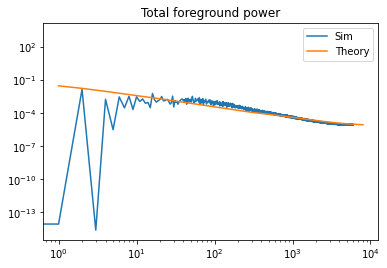

In [20]:
plt.title('Total foreground power')
ls = np.arange(0, len(cltotalfgs))
plt.plot(ls, cltotalfgs, label = 'Sim')
plt.plot(ells, tsz+ksz+radio+cib+dust, label = 'Theory')
plt.yscale('log')
plt.xscale('log')
plt.legend()

### tSZ map plotting

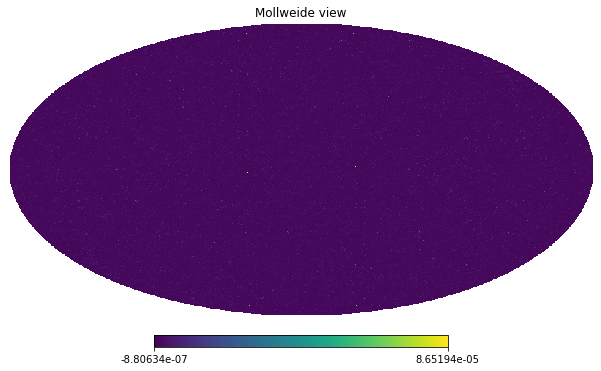

In [21]:
tsz_map = 'tSZ_skymap_healpix_nopell_Nside4096_y_tSZrescale0p75.fits'
tsz_map = hp.read_map(source_dir/tsz_map)
hp.mollview(tsz_map)

In [23]:
total_cl = lcmb+dust+nl145 #any cl that is not a foreground component
total_power = np.interp(ell, ells, total_cl)

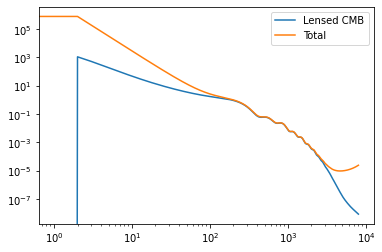

In [27]:
plt.loglog(ells, lcmb, label = 'Lensed CMB')
plt.loglog(ell, total_power, label = 'Total')
plt.legend()

In [28]:
alm_tsz = totalfgs

nomifgs = [kszoutname, tszoutname, radiooutname, ciboutname]
fgmaps = [hp.read_alm(source_dir/f'{nome}_alm.fits')*(fgsu.tsz_factor_for_ymap(freq) if nome == tszoutname else 1) for nome in nomifgs]

### Setting the total foreground map

Sum all foreground maps for a given frequency

In [29]:
alm_tsz = totalfgs

### Matched filter



In [30]:
signal = alm_tsz*0.+1.

lmin, lmax = 100, 5000
prefiltered = filter_alms(alm_tsz, 1./total_power, lmin = lmin, lmax = lmax)


In [31]:
#def matched_filter(mappa, profile, noise_spectrum):
#    hp.almxfl(mappa*profile/)

In [32]:
#filtered_alm = prefiltered*signal
filtered_alm = hp.almxfl(prefiltered, signal)

In [33]:
filtered = hp.alm2map(filtered_alm, nside = nside)

In [34]:
filtered

array([15666503.94139327, 15666511.92407276, 15666527.81198508, ...,
       15666655.31894737, 15666639.23816014, 15666654.22143833])

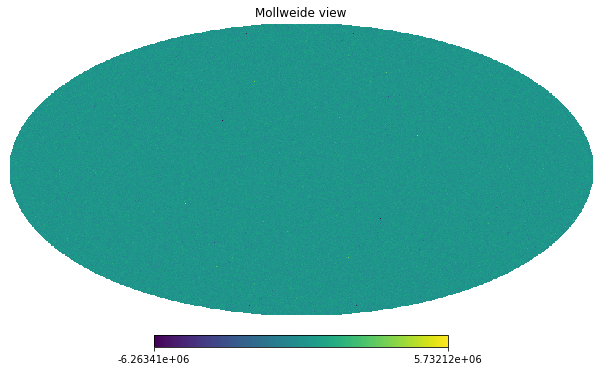

In [35]:
hp.mollview(filtered)

### The SNR map

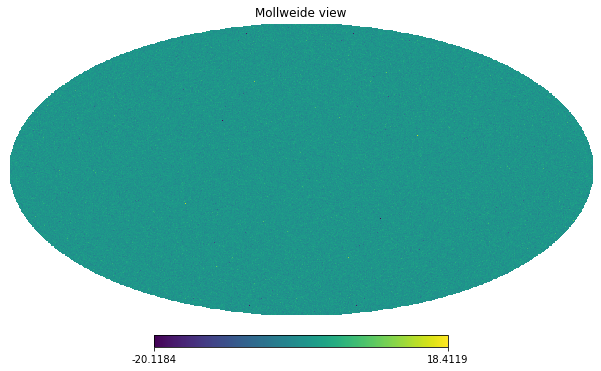

In [36]:
SN_map = filtered / np.std(filtered)
hp.mollview(SN_map)

In [37]:
snr_thr = 5
where = abs(SN_map)>snr_thr
mask = SN_map*0.+1.
mask[where] = 0.

### Points with thresholded SNR

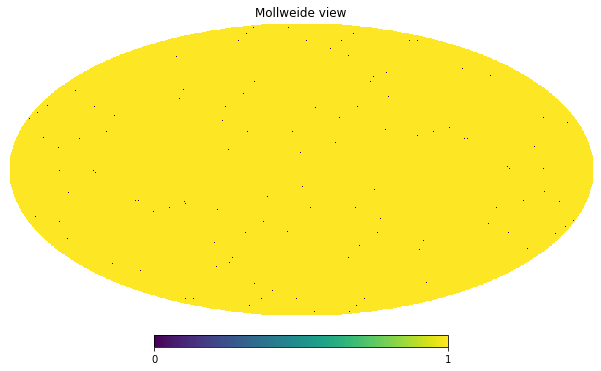

In [38]:
hp.mollview(mask)

In [39]:
def createMaskFromCatalog(cat,nside,fwhm=3*5./60/180.*np.pi):
    mask = np.zeros([12*nside**2])
    mask[cat] = 1
    mask= hp.sphtfunc.smoothing(mask,fwhm)
    mask/=mask.max()
    mask[mask>.3] = -1
    mask[mask!=-1] = 0
    return mask+1

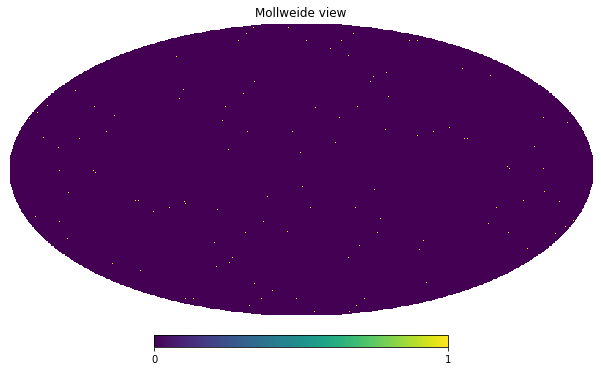

In [40]:
mask_ = 1-mask
hp.mollview(mask_)

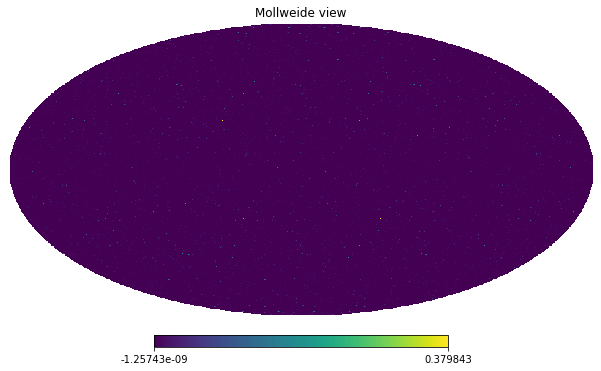

In [41]:
mask_ = 1-mask
fwhm=3*5./60/180.*np.pi
mask__ = hp.sphtfunc.smoothing(mask_, fwhm)
hp.mollview(mask__)

In [46]:
maskf=mask__/mask__.max()
maskf[maskf>.2] = -1
maskf[maskf!=-1] = 0
maskf = maskf+1

### Final Point Source Mask

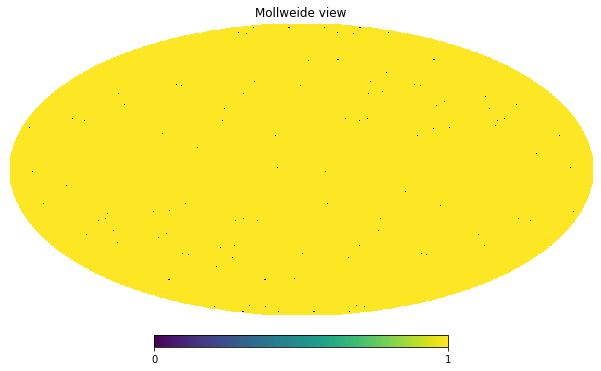

In [47]:
hp.mollview(maskf)

In [48]:
np.mean(maskf)

0.998995969692866

In [50]:
nu = 145
hp.write_map(source_dir/f'source_mask_{nu}GHz.fits', maskf)

setting the output map dtype to [dtype('float64')]


### Checking the tSZ spectra with and without masks

In [51]:
source_dir = pathlib.Path('/global/cscratch1/sd/omard/scatteringtfms/sims/')

nu = 145
maskf = hp.read_map(source_dir/f'source_mask_{nu}GHz.fits')

In [52]:
tsz_map = 'tSZ_skymap_healpix_nopell_Nside4096_y_tSZrescale0p75.fits'
tsz_map = hp.read_map(source_dir/tsz_map)
tsz_map_masked = tsz_map*maskf

In [53]:

#tsz_map_alm = hp.map2alm(tsz_map, lmax = 6000)
#np.save(source_dir/'tsz_map_alm.npy', tsz_map_alm)



In [54]:
tsz_map_masked_alm = hp.map2alm(tsz_map_masked, lmax = 6000)
np.save(source_dir/'tsz_map_masked_alm.npy', tsz_map_masked_alm)

In [ ]:


cl_tsz = hp.alm2cl(tsz_map_alm)
cl_tsz_masked = hp.alm2cl(tsz_map_masked_alm)

In [44]:
l = np.arange(0, len(cl_tsz))

ell, cltsz = np.loadtxt(source_dir/tsz_power, unpack = True)

In [49]:
factor = fgsu.tsz_factor_for_ymap(freq)

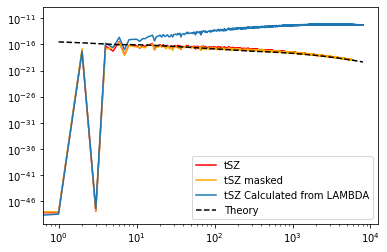

In [50]:
plt.plot(l, cl_tsz, color = 'red', label = 'tSZ')
plt.plot(l, cl_tsz_masked, color = 'orange', label = 'tSZ masked')
plt.plot(ell, cltsz, label = 'tSZ Calculated from LAMBDA')
plt.plot(ells, tsz/factor**2, ls = '--', color = 'black', label = 'Theory')
plt.yscale('log')
plt.xscale('log')
plt.legend()